# Viral Data Analysis

Date: 2020.10.26

Author: © 2020 Nela Petrželková

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from https://ourworldindata.org/ to answer the following questions:

1. [Are more tests performed in countries with higher GDP per capita?](#Q1)
1. [Does higher diabetes prevalence implies that the country has higher mortality rate among infected people?](#Q2)
1. [Lockdown in Czech Republic](#Q3)

Additional data from:
* https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19
* https://onemocneni-aktualne.mzcr.cz/covid-19/prehled-hospitalizaci


This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [2]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

11597936

Load the file to Pandas.

In [3]:
# url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

In [4]:
df.date.max()

Timestamp('2020-10-26 00:00:00')

Show the information about columns in the dataframe. The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52661 entries, 0 to 52660
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   iso_code                         52360 non-null  object        
 1   continent                        52059 non-null  object        
 2   location                         52661 non-null  object        
 3   date                             52661 non-null  datetime64[ns]
 4   total_cases                      49047 non-null  float64       
 5   new_cases                        51768 non-null  float64       
 6   new_cases_smoothed               50974 non-null  float64       
 7   total_deaths                     40132 non-null  float64       
 8   new_deaths                       51768 non-null  float64       
 9   new_deaths_smoothed              50974 non-null  float64       
 10  total_cases_per_million          48782 non-null  float64  

## Data quality report

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_cases,49047.0,1.397606e+05,1.400688e+06,1.000,1.460000e+02,1.776000e+03,1.756200e+04,4.314017e+07
new_cases,51768.0,1.666635e+03,1.508072e+04,-8261.000,0.000000e+00,1.200000e+01,1.980000e+02,4.790850e+05
new_cases_smoothed,50974.0,1.640664e+03,1.471313e+04,-552.000,7.140000e-01,1.757100e+01,2.081430e+02,4.243094e+05
total_deaths,40132.0,6.222143e+03,5.040354e+04,1.000,1.100000e+01,7.400000e+01,6.230000e+02,1.155235e+06
new_deaths,51768.0,4.462975e+01,3.718850e+02,-1918.000,0.000000e+00,0.000000e+00,3.000000e+00,1.049100e+04
new_deaths_smoothed,50974.0,4.466321e+01,3.615044e+02,-232.143,0.000000e+00,2.860000e-01,3.571000e+00,7.456857e+03
total_cases_per_million,48782.0,2.573356e+03,5.079540e+03,0.001,7.480600e+01,4.957860e+02,2.875122e+03,5.226170e+04
new_cases_per_million,51704.0,3.103568e+01,1.098810e+02,-2212.545,0.000000e+00,1.897500e+00,2.223825e+01,8.652658e+03
new_cases_smoothed_per_million,50909.0,3.009664e+01,7.601642e+01,-269.978,2.090000e-01,3.489000e+00,2.504800e+01,2.472188e+03
total_deaths_per_million,39882.0,8.642907e+01,1.707367e+02,0.000,3.450000e+00,1.803350e+01,7.373900e+01,1.237551e+03


Group the dataframe by country code, which will come in handy later.

In [7]:
df_grouped = df.groupby('iso_code').last()

<a id='Q1'></a>
## 1. Are more tests performed in countries with higher GDP per capita? 
The goal of this part is to analyze if countries with higher GDP are testing their citizen more. 
### Least Squares Solution
I will interpolate the data by means of Least Squares Fit method. The mathematial problem I am solving is the following:
<center>$\min_{x \in \mathbb{R^n}}||Ax - y||$</center>

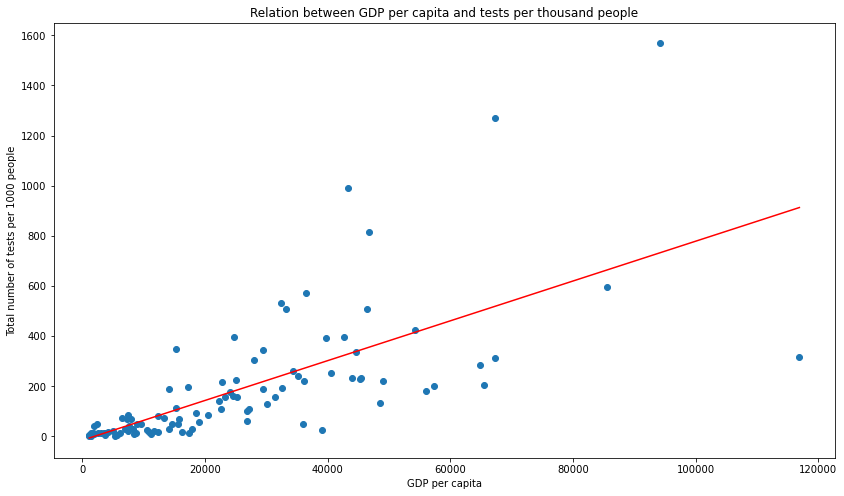

In [8]:
# Filter the dataframe from NaN values in the desired columns
df1 = df_grouped.dropna(subset=['gdp_per_capita', 'total_tests_per_thousand'])

# Obtain the desired features from dataset
gdp = df1.gdp_per_capita
tests = df1.total_tests_per_thousand

# Plot the features
plt.figure(figsize=(14,8))
plt.scatter(gdp, tests)
plt.xlabel('GDP per capita')
plt.ylabel('Total number of tests per 1000 people')

# Least Squares Fit
# Add column of ones to create matrix A
A = np.vstack([gdp, np.ones(len(gdp))]).T
y = tests
w, b = np.linalg.lstsq(A, y, rcond=None)[0]
# Two points are enough to make a line
x_fit = np.linspace(gdp.min(), gdp.max(), 2)
y_fit = b + w * x_fit
plt.plot(x_fit, y_fit, color='r')
plt.title('Relation between GDP per capita and tests per thousand people')
plt.show()

### Correlation
We can see if and how are those features correlated. Correlation is calculated as in the formula below.
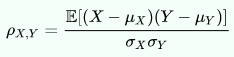

In [9]:
gdp.corr(tests)

0.6845241533187838

We can see that the correlation between GDP per capita and tests is a relatively high positive number already in a linear scale, which means that richer countries are indeed testing people more.

<a id='Q2'></a>
## 2. Does higher diabetes prevalence implies that the country has higher mortality rate among infected people?

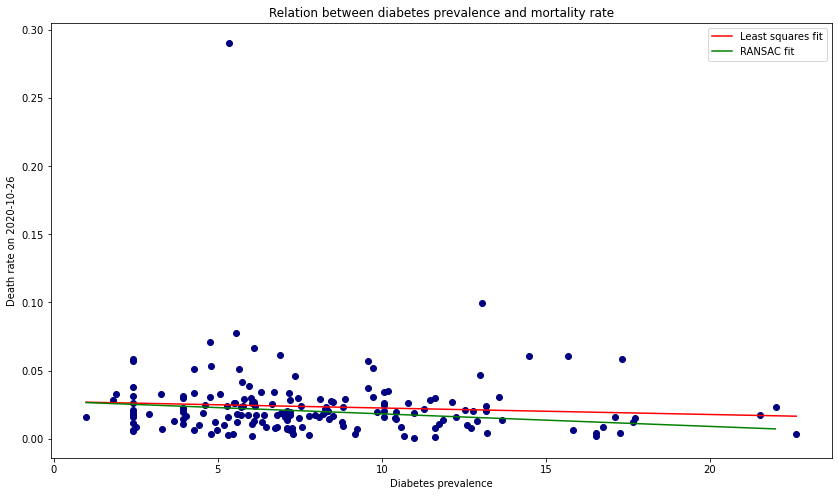

In [10]:
df2 = df_grouped.dropna(subset=['diabetes_prevalence', 'total_cases', 'total_deaths'])
diabetes = df2.diabetes_prevalence
cases = df2.total_cases
deaths = df2.total_deaths
death_rate = (deaths/cases)
# Plot the features
plt.figure(figsize=(14,8))
plt.scatter(diabetes, death_rate, color='navy')
plt.xlabel('Diabetes prevalence')
plt.ylabel('Death rate on {}'.format(df['date'].dt.date.max()))

# Least Squares Fit
# Add column of ones to create matrix A
A = np.vstack([diabetes, np.ones(len(diabetes))]).T
y = death_rate
w, b = np.linalg.lstsq(A, y, rcond=None)[0]
# Two points are enough to make a line
x_fit = np.linspace(diabetes.min(), diabetes.max(), 2)
y_fit = b + w * x_fit
plt.plot(x_fit, y_fit, color='r', label='Least squares fit')

# # Because this is quite similar to the first question I will use RANSAC
# # algorithm for line fitting, as this approach is quite outlier-proof
from sklearn import linear_model
ransac = linear_model.RANSACRegressor()
ransac.fit(diabetes[:, np.newaxis], death_rate)
x = np.arange(diabetes.min(), diabetes.max())[:, np.newaxis]
y = ransac.predict(x)
plt.plot(x, y, color='g', label='RANSAC fit')
plt.title('Relation between diabetes prevalence and mortality rate')
plt.legend()
plt.show()

In [11]:
death_rate.corr(diabetes)

-0.07707644935582572

Ok, doesn't really look like it is somehow correlated. Let's try log log scale, maybe it will be better..

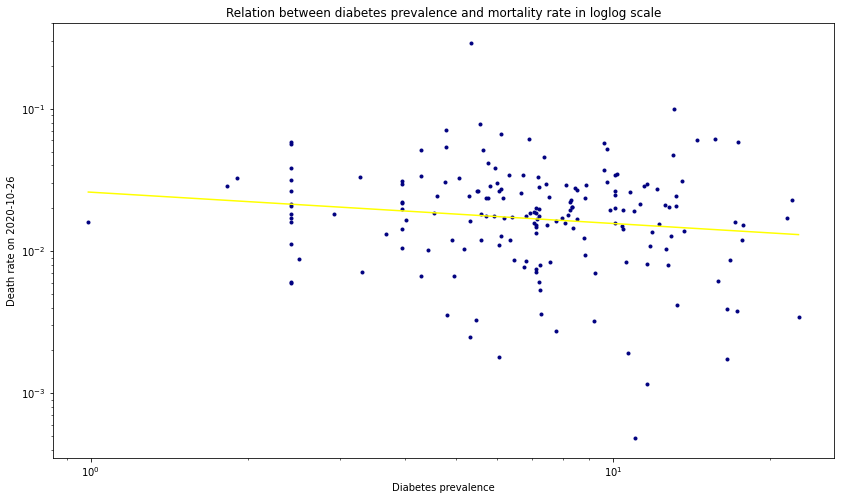

In [12]:
plt.figure(figsize=(14,8))
plt.loglog(diabetes, death_rate, '.', color='navy')
plt.xlabel('Diabetes prevalence')
plt.ylabel('Death rate on {}'.format(df['date'].dt.date.max()))
w1, w0 = ma.polyfit(np.log(diabetes), np.log(death_rate), 1)
x_all = np.linspace(np.log(diabetes.min()), np.log(diabetes.max()), 100)
plt.plot(np.exp(x_all), np.exp(w0 + w1 * x_all), '-', color='yellow')
plt.title('Relation between diabetes prevalence and mortality rate in loglog scale')
plt.show()

In [13]:
np.log(death_rate).corr(np.log(diabetes))

-0.14174280643857304

Okay, it is not. Specialists say that coronavirus is more dangerous for people with diabetes, but we cannot really see it in the data. The reason can be that we have just diabetes prevalence among all citizens, not among the infected.

<a id='Q3'></a>
## 3. Lockdown in Czech Republic 

In the meantime before I started working on this mini-project, the second lockdown in the Czech Republic already came, it was declared on 22nd October 2020. I want to analyze, if it is early enough to save our health system from collapsing and early enough to have enough artificial ventilators and other means that people in serious condition need.

### Overall statistics

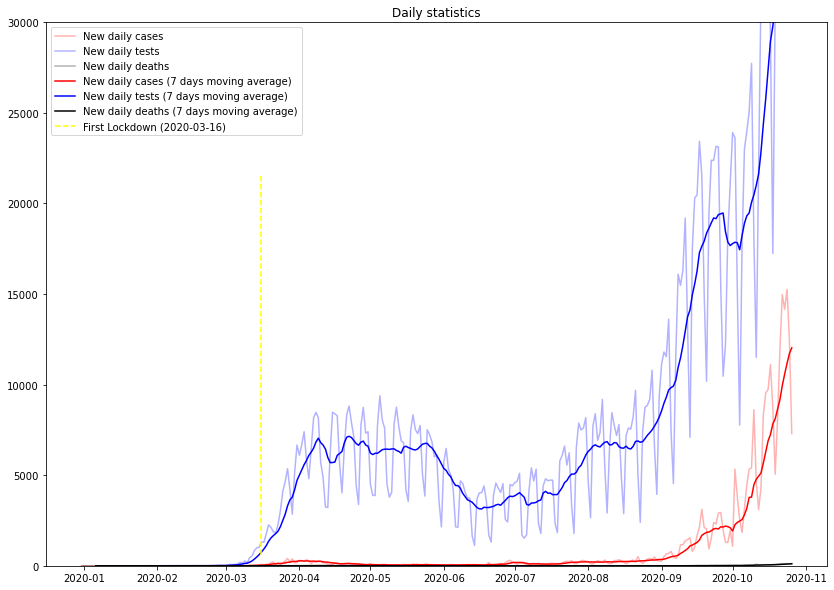

In [14]:
cz = df.loc[df['iso_code'] == 'CZE']

plt.figure(figsize=(14,10))
x = cz['date']
cases = cz['new_cases']
tests = cz['new_tests']
deaths = cz['new_deaths']
cases_smoothed = cz['new_cases_smoothed']
tests_smoothed = cz['new_tests_smoothed']
deaths_smoothed = cz['new_deaths_smoothed']
plt.plot(x, cases, label='New daily cases', color='red', alpha=0.3)
plt.plot(x, tests, label='New daily tests', color='blue', alpha=0.3)
plt.plot(x, deaths, label='New daily deaths', color='black', alpha=0.3)
plt.plot(x, cases_smoothed, label='New daily cases (7 days moving average)', color='red')
plt.plot(x, tests_smoothed, label='New daily tests (7 days moving average)', color='blue')
plt.plot(x, deaths_smoothed, label='New daily deaths (7 days moving average)', color='black')
lockdown = dt.datetime(2020, 3, 16)
plt.axvline(lockdown, color='yellow', ymin=0.02, ymax=0.72, label='First Lockdown ({})'.format(lockdown.date()), linestyle='--')
plt.ylim(0, 30000)
plt.legend(loc='upper left')
plt.title('Daily statistics')
plt.show()

We can see that the numbers of new cases started to grow exponentially, so the lockdown was inevitable.

### Growing positive rate

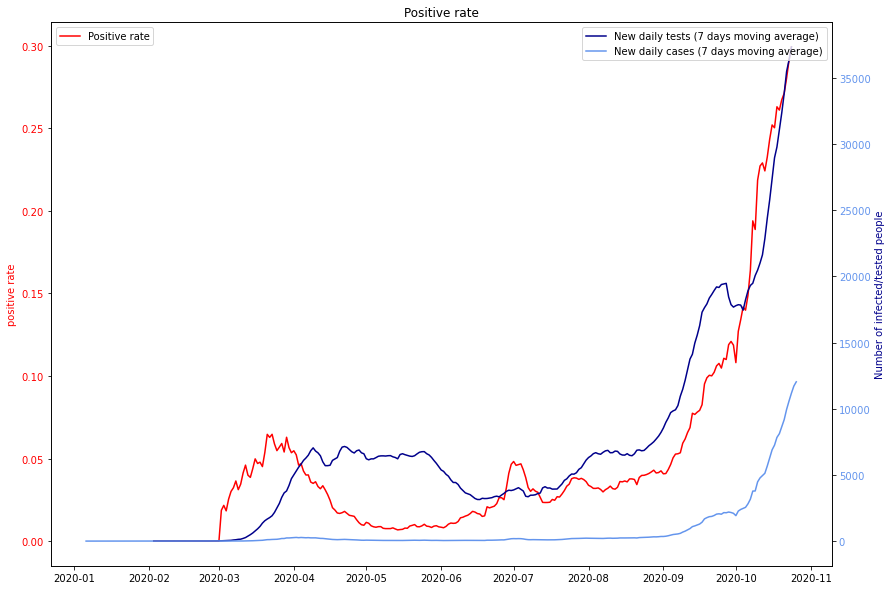

In [15]:
fig, ax1 = plt.subplots(figsize=(14,10))
x = cz.date

positive_rate = cz.new_cases_smoothed/cz.new_tests_smoothed
ax1.plot(x, positive_rate, label='Positive rate', color='red')
ax1.set_ylabel('positive rate', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x, tests_smoothed, label='New daily tests (7 days moving average)', color='darkblue')
ax2.plot(x, cases_smoothed, label='New daily cases (7 days moving average)', color='cornflowerblue')
ax2.set_ylabel('Number of infected/tested people', color='darkblue')
ax2.tick_params(axis='y', labelcolor='cornflowerblue')
ax2.legend(loc='upper right')

plt.title('Positive rate')
plt.show()

Also not only the absolute number of positive people is growing but also the ratio of positive tests is higher and higher, theses around 28% of tested people are positive. 

### Capacities for people in serious conditions
I used additional data from Czech ministry of health (https://onemocneni-aktualne.mzcr.cz/covid-19). I had to combine several dataframes to get information needed. The dataframe in cell below contains information about hospitalized people and people being in serious condition on a given date.

In [16]:
hosp = pd.read_csv('hospitalizace.csv')
hosp['date'] = pd.to_datetime(hosp['date'], format='%d.%m.%Y')
hosp['hospitalized'] = pd.to_numeric(hosp['hospitalized'])
hosp = hosp.iloc[::-1]
hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 227 to 0
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        228 non-null    datetime64[ns]
 1   hospitalized                228 non-null    int64         
 2   serious_condition           228 non-null    int64         
 3   serious_condition_percent   228 non-null    object        
 4   home_from_hospital          228 non-null    object        
 5   home_from_hospital_percent  228 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.8+ KB


This dataframe contains information about capacities of our health system. There are columns like overall count of ventilator, beds on intensive care units, capacities of doctors and nurses and we have also percentages of those resources currently available.

In [17]:
cap_df = pd.read_csv('kapacity-nemocnic.csv')
cap_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Datum                                           199 non-null    object
 1   UPV Celkem kapacita                             199 non-null    object
 2   UPV Volná kapacita                              199 non-null    object
 3   UPV Volná kapacita v %                          199 non-null    object
 4   ECMO Celkem kapacita                            199 non-null    int64 
 5   ECMO Volná kapacita                             199 non-null    int64 
 6   ECMO Volná kapacita v %                         199 non-null    object
 7   CRRT Celkem kapacita                            199 non-null    int64 
 8   CRRT Volná kapacita                             199 non-null    int64 
 9   CRRT Volná kapacita v %                         199 no

Some data cleaning here. I had to transform the dates to datetime format and change format and type of the numerical values, because they were considered objects (because of the comma after thousand units).

In [18]:
from pandas.api.types import is_string_dtype

for column in cap_df:
    col = cap_df[column]
    if column == 'Datum':
        pd.to_datetime(cap_df[column], format='%m/%d/%Y')
        continue
    if is_string_dtype(col):
        if "%" in col.iloc[0]:
            continue
        else:
            y = col.tolist()
            y = [s.replace(",","") for s in y]
            cap_df[column] = y
            cap_df[column] = pd.to_numeric(cap_df[column])

cap_df['Datum'] = pd.to_datetime(cap_df['Datum'], format='%m/%d/%Y')
cap_df = cap_df.sort_values(by='Datum')        

### Capacities related to hospilazited people

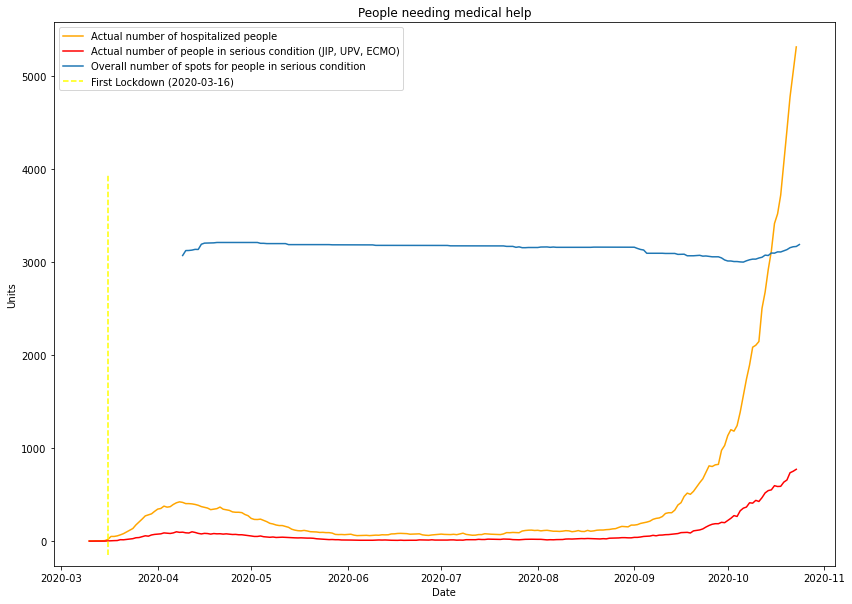

In [19]:
fig, ax1 = plt.subplots(figsize=(14,10))
x = hosp.date
lockdown = dt.datetime(2020, 3, 16)
capacity = cap_df['UPV Celkem kapacita'] + cap_df['Vent. sál (celkem)'] + cap_df['ECMO Celkem kapacita'] + cap_df[' Ventilátory přenosné (celkem)']
ax1.plot(x, hosp.hospitalized, label='Actual number of hospitalized people', color='orange')
ax1.plot(x, hosp.serious_condition, label='Actual number of people in serious condition (JIP, UPV, ECMO)', color='red')
ax1.plot(cap_df['Datum'], capacity, label='Overall number of spots for people in serious condition')
ax1.axvline(lockdown, color='yellow', ymin=0.02, ymax=0.72, label='First Lockdown ({})'.format(lockdown.date()), linestyle='--')
ax1.legend()
plt.ylabel('Units')
plt.xlabel('Date')
plt.title('People needing medical help')
plt.show()

Sadly, we can see that the number of hospitalized people also grows exponentially, similarly as the number of positive people. Looks like number of people who had to be hospitalized is a multiple od people in serious condition..

In [20]:
corr = hosp.hospitalized.corr(hosp.serious_condition)
corr

0.9879302900733434

In [21]:
ratio = hosp.serious_condition/hosp.hospitalized
ratio = ratio[ratio > 0]
avg = np.average(ratio)
std = np.std(ratio)
print('Average: ', avg, '| standard deviation: ', std)

Average:  0.20288726327066003 | standard deviation:  0.044970978593803015


Beause correlation between hospitalized people and people in serious conditions is almost 1, I just divided those variables and see that around 20% of all hospitalized people is in serious conditions. The standard devation is small so this ratio is quite constant, which means that it is around 20% at any time. So it basically means that every fifth person being hospitalized ends up in serious condition.


### Lockdown effect

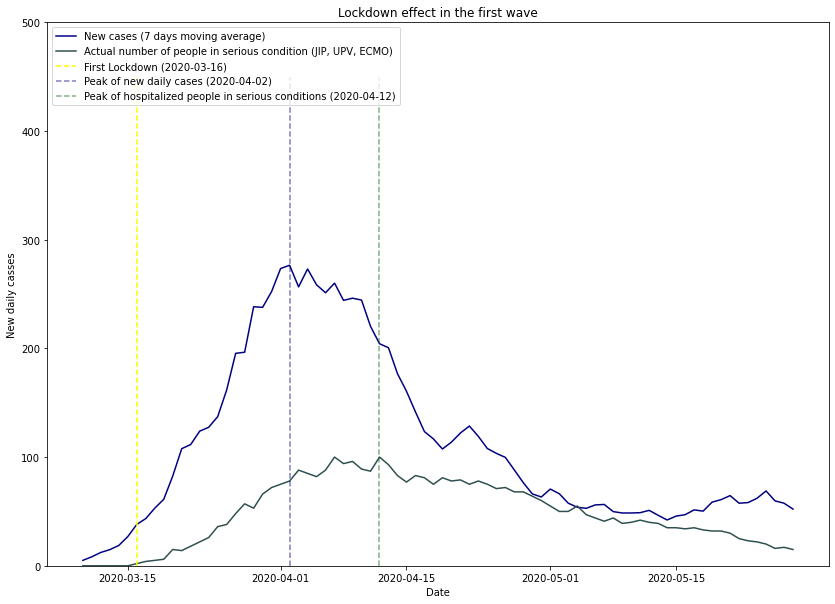

In [22]:
cz = df.loc[df['iso_code'] == 'CZE']
plt.figure(figsize=(14,10))
x = cz['date'].iloc[70:150]
cases_smoothed = cz['new_cases_smoothed'].iloc[70:150]
lockdown = dt.datetime(2020, 3, 16)
max_idx = np.argmax(cases_smoothed)
date = x.iloc[max_idx]
max_serious = np.argmax(hosp.serious_condition[:80])
plt.plot(x, cases_smoothed, label='New cases (7 days moving average)', color='navy')
plt.plot(x, hosp.serious_condition[:80], label='Actual number of people in serious condition (JIP, UPV, ECMO)', color='darkslategray')
plt.axvline(lockdown, color='yellow', ymin=0, ymax=0.9, label='First Lockdown ({})'.format(lockdown.date()), linestyle='--')
plt.axvline(date, color='navy', ymin=0, ymax=0.9, label='Peak of new daily cases ({})'.format(date.date()), linestyle='--', alpha=0.5)
plt.axvline(x.iloc[max_serious+5], color='darkgreen', ymin=0, ymax=0.9, label='Peak of hospitalized people in serious conditions ({})'.format(x.iloc[max_serious+5].date()), linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.title('Lockdown effect in the first wave')
plt.ylabel('New daily casses')
plt.xlabel('Date')
plt.ylim((0,500))
plt.show()

In [23]:
from scipy.optimize import curve_fit

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

2020-03-10 00:00:00
(Timestamp('2020-03-21 00:00:00'), -46.04304629947005)
2020-03-26 00:00:00


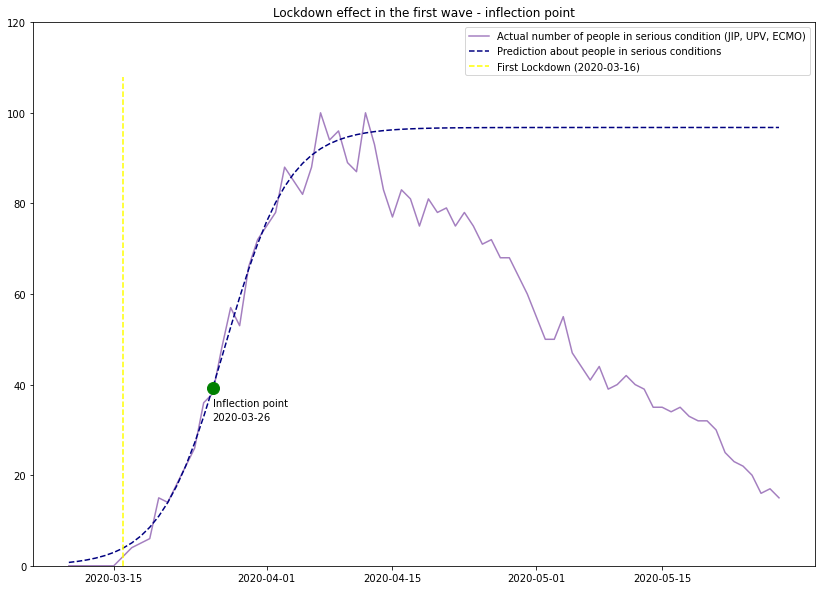

In [24]:
cz = df.loc[df['iso_code'] == 'CZE']
plt.figure(figsize=(14,10))
x = cz['date'].iloc[70:150]
x_int = np.arange(len(x))
y = hosp.serious_condition[:80]
plt.plot(x, y, label='Actual number of people in serious condition (JIP, UPV, ECMO)', color='indigo', alpha=0.5)

# Fit the logistic curve
end = 30
popt, pcov = curve_fit(log_curve, np.arange(end), y[:end], bounds=([0,0,0],np.inf), maxfev=50000)
k, x_0, ymax = popt
length = 80
smoothed = log_curve(range(0,length), k, x_0, ymax)
print(x.iloc[0])
x_dt = pd.date_range(x.iloc[0], periods=length, freq='d')
plt.plot(x_dt, smoothed, '--', label='Prediction about people in serious conditions', color='navy')

# Find and plot the inflection point
start_idx = 5
end_idx = 30
snd_derivatives = np.diff(smoothed[start_idx:end_idx], n=2)
inflection = np.where(snd_derivatives > 0)[0][-1]
inflection_date = x.iloc[inflection+start_idx]
print((x.iloc[inflection], smoothed[inflection]-60))
print(inflection_date)
plt.plot(x.iloc[inflection+start_idx], smoothed[inflection+start_idx], 'o', color='green', markersize=12)
plt.annotate('Inflection point', (x.iloc[inflection+start_idx], smoothed[inflection+start_idx]-4), color='black')
plt.annotate(x.iloc[inflection+start_idx].date(), (x.iloc[inflection+start_idx], smoothed[inflection+start_idx]-7), color='black')

# Plot lockdown date
lockdown = dt.datetime(2020, 3, 16)
plt.axvline(lockdown, color='yellow', ymin=0, ymax=0.9, label='First Lockdown ({})'.format(lockdown.date()), linestyle='--')

plt.title('Lockdown effect in the first wave - inflection point')
plt.ylim((0, 120))
plt.legend()
plt.show()

After the first lockdown, which was declared on 16th March, the cases started to decrease on 2nd April 2020, so it took 16 days to see the effect of the lockdown. The numbers of people of people in serious condition is hospital started to decrease 10 days later. So we alleviated the hospitals after 26 days. Let\'s use this fact in predicting the situation during the second wave.

### Prediction
Based on the data from the first wave, I am trying to predict, whether we will have enough ventilators and other equipment for people in serious conditions.

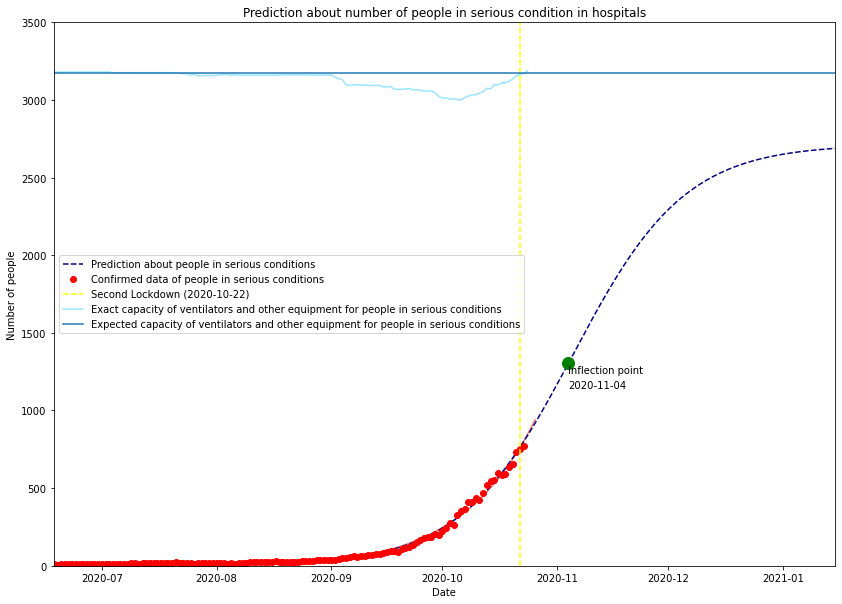

In [25]:
y_data = hosp.serious_condition.iloc[100:]  # Starting from 100th position because now we care only about 2nd wave
days = hosp['date'].iloc[100:]
start_date = days.iloc[0]
x_data = pd.date_range(days.iloc[0], periods=len(days), freq='d')
x_ints = np.arange(len(days))
plt.figure(figsize=(14,10))

# Simulate exponential growth until the inflection point (so 10 days after the lockdown)
def func(x, a, b, c, d):
    return a*np.exp(-c*(x-b))+d

# I fit the line so that the inflection point is same
x_ints_future = np.arange(len(days)+3)
popt, pcov = curve_fit(func, x_ints[70:], y_data[70:], [100,400,0.001,0])
y_pred = func(x_ints_future, *popt)
x_dt = pd.date_range(days.iloc[0], periods=len(y_pred), freq='d')
plt.plot(x_dt, y_pred, color='salmon')
y_pred = np.hstack((y_data, y_pred[len(y_data):]))

# Predict how the number of people in serious condition will grow (logistic regression)
popt, pcov = curve_fit(log_curve, x_ints_future, y_pred, bounds=([0,0,0],np.inf), maxfev=50000)
k, x_0, ymax = popt
length = 270
y_fitted = log_curve(range(0, length), k, x_0, ymax)
x_dt = pd.date_range(days.iloc[0], periods=length, freq='d')
plt.plot(x_dt, y_fitted, '--', label='Prediction about people in serious conditions', color='navy')

# Plot data about people in serious condition
plt.plot(x_data, y_data, 'o', label='Confirmed data of people in serious conditions', color='red')

# Plot the lockdown and expected peak of the number of people in serious condition
lockdown = dt.datetime(2020, 10, 22)
max_cases = pd.date_range(lockdown, periods=26, freq='d')[-1]
plt.axvline(lockdown, color='yellow', label='Second Lockdown ({})'.format(lockdown.date()), linestyle='--')

# Find and plot the inflection point
snd_derivatives = np.diff(y_fitted, n=2)
inflection = np.where(snd_derivatives > 0)[0][-1]
plt.plot(x_dt[inflection], y_fitted[inflection], 'o', color='green', markersize=12)
plt.annotate('Inflection point', (x_dt[inflection], y_fitted[inflection]-60))
plt.annotate(x_dt[inflection].date(), (x_dt[inflection], y_fitted[inflection]-160))


plt.plot(cap_df['Datum'], capacity, label='Exact capacity of ventilators and other equipment for people in serious conditions', color='deepskyblue', alpha=0.4)
y_pos = scipy.stats.mode(capacity)[0]
plt.axhline(y_pos, label='Expected capacity of ventilators and other equipment for people in serious conditions')
plt.ylim((0, 3500))
plt.xlim((start_date, dt.datetime(2021, 1, 15)))
plt.legend()
plt.title('Prediction about number of people in serious condition in hospitals')
plt.xlabel('Date')
plt.ylabel('Number of people')
plt.show()

Given the inflection point will come +- day 10 days after lockdown, like in the first wave, we can predict, that we will have enough ventilators and other equipment for people in serious condition. 